In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import wrangle
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data

import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# SPLITTING UP THE DATA HERE BASED ON A TSA APPROACH
### Other of our explorations might work slightly differently, if we do a prediction model or topic modeling

In [2]:
# df = pd.read_csv('npr_corpus.csv')
# df.head()

In [3]:
df = wrangle.get_npr_data()
df.head()

The df has 1889857 rows and 12 columns.


,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,"ms. loren mooney (editor-in-chief, bicycling m...","It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,"ms. loren mooney (editor-in-chief, bicycling m...",So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,"neal conan, host","So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,"ms. loren mooney (editor-in-chief, bicycling m...",That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,"neal conan, host","So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12


In [4]:
# This should be in wrangle now

# df['speaker'] = df.speaker.str.lower()
# df['is_host'] = df.speaker.str.contains(r'\W*(host)\W*')

In [5]:
df.sort_values(by=['episode_id','episode_order'])[0:50]

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
13231,17,1,"melissa block, host",He is in cahoots with a foreign government to ...,weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,he is in cahoots with a foreign government to ...,he is in cahoot with a foreign government to m...,-0.8176,2019-09-22
13232,17,2,"melissa block, host",Let's hear now from another Democrat. Tom Mali...,weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,let s hear now from another democrat. tom mali...,let s hear now from another democrat. tom mali...,0.4404,2019-09-22
13233,17,3,tom malinowski,Good morning.,weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,good morning .,good morning .,0.4404,2019-09-22
13234,17,4,"melissa block, host",I'd like first to get your response to the Tru...,weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,i d like first to get your response to the tru...,i d like first to get your response to the tru...,0.3612,2019-09-22
13235,17,5,tom malinowski,"Well, first of all, it's illegal. We have a ve...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,"well , first of all , it s illegal. we have a ...","well , first of all , it s illegal. we have a ...",0.8680,2019-09-22
13236,17,6,"melissa block, host","Now, we should explain that this has to do, ac...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,"now , we should explain that this has to do , ...","now , we should explain that this ha to do , a...",0.5106,2019-09-22
13237,17,7,tom malinowski,"Look. I think there is a very, very big leap b...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,"look. i think there is a very , very big leap ...","look. i think there is a very , very big leap ...",0.7783,2019-09-22
13238,17,8,"melissa block, host","And you say, if it's true...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,"and you say , if it s true ...","and you say , if it s true ...",0.4215,2019-09-22
13239,17,9,tom malinowski,"And yes, impeachable.",weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,"and yes , impeachable .","and yes , impeachable .",0.4019,2019-09-22
13240,17,10,"melissa block, host","You say, if it's true, what powers does the Ho...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,"you say , if it s true , what powers does the ...","you say , if it s true , what power doe the ho...",0.4215,2019-09-22


## Is there a difference in the mean sentiment by speaker? Program? etc
- Applied statistics-> i.e. stats testing. Is there a difference in the mean sentiment by speaker? Program? etc 

In [6]:
df.columns

Index(['episode_id', 'episode_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized', 'vader', 'date'],
      dtype='object')

In [7]:
df.shape

(1889857, 11)

In [8]:
df.dtypes

episode_id         int64
episode_order      int64
speaker           object
utterance         object
program           object
title             object
is_host             bool
clean             object
lemmatized        object
vader            float64
date              object
dtype: object

In [9]:
df.date = pd.to_datetime(df.date)

In [10]:
df.dtypes

episode_id                int64
episode_order             int64
speaker                  object
utterance                object
program                  object
title                    object
is_host                    bool
clean                    object
lemmatized               object
vader                   float64
date             datetime64[ns]
dtype: object

In [11]:

# df['Date'].dt.strftime('%b-%Y')

# df['episode_date'].dt.strftime('%b')

In [12]:
df['month']=df['date'].dt.strftime('%b')
df['year']=pd.DatetimeIndex(df['date']).year
df=df.reset_index()
df.head()

,index,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,month,year
0,0,57264,9,"ms. loren mooney (editor-in-chief, bicycling m...","It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12,Jul,2010
1,1,57264,10,"ms. loren mooney (editor-in-chief, bicycling m...",So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12,Jul,2010
2,2,57264,11,"neal conan, host","So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12,Jul,2010
3,3,57264,12,"ms. loren mooney (editor-in-chief, bicycling m...",That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12,Jul,2010
4,4,57264,13,"neal conan, host","So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12,Jul,2010


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df=df.set_index('date').sort_index()

In [15]:
df = df[df.index.year >= 2005]

In [16]:
df.head(1)

,index,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,month,year
date,,,,,,,,,,,,,
2005-01-11,1793827,84432,85,"neal conan, host",OK.,talk of the nation,difference between a think and a 'blink',True,ok .,ok .,0.296,Jan,2005


In [17]:
train = df[:'2015']
validate = df['2016':'2017']
test = df['2018':]
train.shape, validate.shape, test.shape

((1665131, 13), (129513, 13), (95213, 13))

In [18]:
train.index[-1:], validate.index[:1], validate.index[-1:], test.index[:1]

(DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2016-01-01'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2017-12-29'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2018-01-01'], dtype='datetime64[ns]', name='date', freq=None))

<AxesSubplot:>

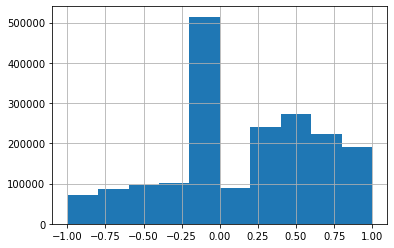

In [19]:
df.vader.hist()

## Using train split from here

In [20]:
host_df = train[train.is_host==True]

In [21]:
guest_df = train[train.is_host!=True]

In [22]:
host_df.shape, guest_df.shape

((599253, 13), (1065878, 13))

In [23]:
host_df.shape

(599253, 13)

In [24]:
# are there repeats in the host_df? 
host_df.speaker.value_counts()

neal conan, host                                      255143
ira flatow, host                                       73188
robert siegel, host                                    43704
steve inskeep, host                                    41416
melissa block, host                                    38682
                                                       ...  
malowi humdella, host                                      1
susan stamberg (host)                                      1
melissa block host                                         1
mr. keith olbermann (host, "countdown," msnbc)             1
mr. rush limbaugh (host, "the rush limbaugh show")         1
Name: speaker, Length: 447, dtype: int64

- I can see two different duplicates for steve inskeep bc of typos
- I think this is going to fall into the arena of significantly diminishing returns, and I will not address it at this time

In [25]:
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

- This is a list of the 12 hosts with the most observations

In [26]:
hosts_with_the_most

['neal conan, host',
 'ira flatow, host',
 'robert siegel, host',
 'steve inskeep, host',
 'melissa block, host',
 'farai chideya, host',
 'renee montagne, host',
 'scott simon, host',
 'david greene, host',
 'rachel martin, host']

In [27]:
top_hosts_df = train[train.speaker.isin(hosts_with_the_most)]


In [28]:
top_hosts_df.head(1)

,index,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,month,year
date,,,,,,,,,,,,,
2005-01-11,1793827,84432,85,"neal conan, host",OK.,talk of the nation,difference between a think and a 'blink',True,ok .,ok .,0.296,Jan,2005


In [29]:
top_hosts_df.index.min(), top_hosts_df.index.max()

(Timestamp('2005-01-11 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [30]:
top_hosts_df.vader.mean()

0.15796677819555985

- Here, we have the average sentiment score for all the top hosts; as you can see, it is relatively neutral in sentiment

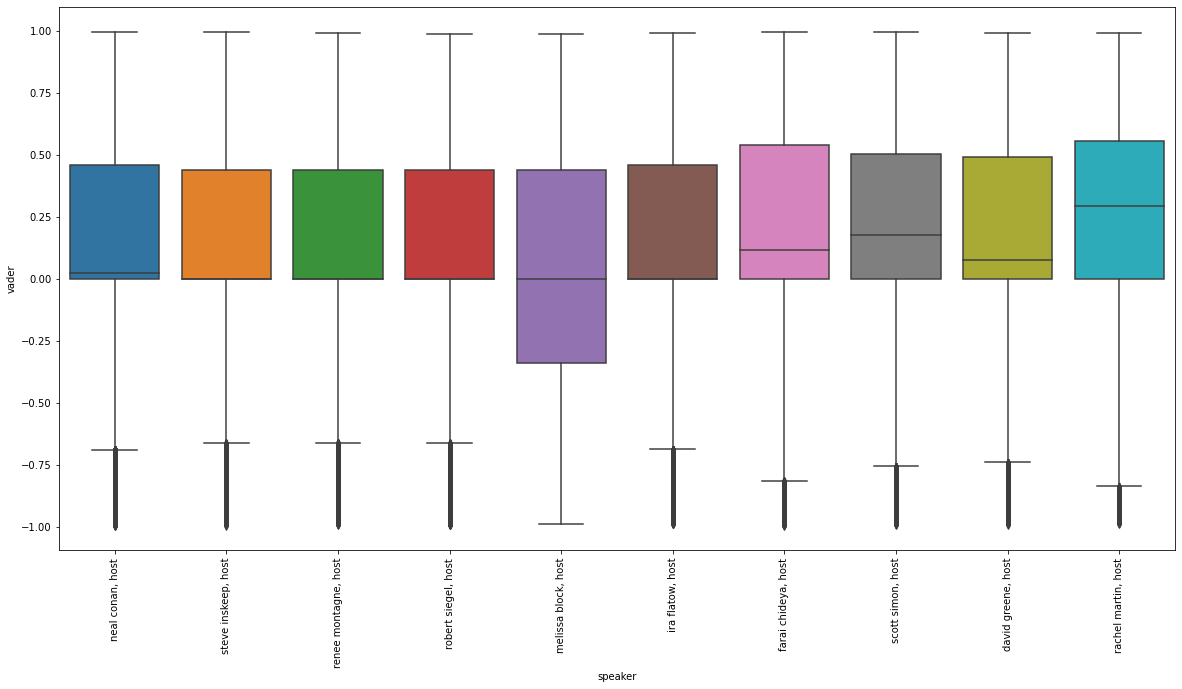

In [31]:
plt.figure(figsize=(20,10))
sns.boxplot(data=top_hosts_df, x='speaker',y='vader')
plt.xticks(rotation=90);

- The mean sentiment value is awfully close for everyone here, so i'm going to stats test it with an ANOVA test

In [32]:
null_hypothesis = "Average sentiment score is the same across hosts"
alternative_hypothesis = "Average sentiment score is different in at least one host of the group"
alpha = 0.01 # Let's be 99% certain the result we see isn't due to chance/randomness

In [33]:
host_df_list=[]
for host in hosts_with_the_most:
    x = host.split()
    host_df_list.append(f'{x[0]}_df')
print(host_df_list)

['neal_df', 'ira_df', 'robert_df', 'steve_df', 'melissa_df', 'farai_df', 'renee_df', 'scott_df', 'david_df', 'rachel_df']


In [34]:
hosts_with_the_most

['neal conan, host',
 'ira flatow, host',
 'robert siegel, host',
 'steve inskeep, host',
 'melissa block, host',
 'farai chideya, host',
 'renee montagne, host',
 'scott simon, host',
 'david greene, host',
 'rachel martin, host']

In [35]:
# Let's isolate our hosts
NEAL_df = train[train.speaker == 'neal conan, host'].vader
IRA_df = train[train.speaker ==  'ira flatow, host'].vader
ROBERT_df = train[train.speaker == 'robert siegel, host'].vader
STEVE_df = train[train.speaker == 'steve inskeep, host'].vader
MELISSA_df = train[train.speaker == 'melissa block, host'].vader
FARAI_df = train[train.speaker ==  'farai chideya, host'].vader
RENEE_df = train[train.speaker == 'renee montagne, host'].vader
SCOTT_df = train[train.speaker == 'scott simon, host'].vader
DAVID_df = train[train.speaker == 'david greene, host'].vader
RACHEL_df = train[train.speaker == 'rachel martin, host'].vader


# GUY_df = train[train.speaker == 'guy raz, host'].vader_stopped
# MADELEINE_df = train[train.speaker == 'madeleine brand, host'].vader_stopped
# MICHELE_df = train[train.speaker == 'michelle norris, host'].vader_stopped
# ALEX_df = train[train.speaker == 'alex chadwick, host'].vader_stopped


In [36]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(NEAL_df, IRA_df, ROBERT_df, STEVE_df, MELISSA_df, FARAI_df, RENEE_df, SCOTT_df, DAVID_df, RACHEL_df)
f, p

(688.1290185924315, 0.0)

In [37]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that Average sentiment score is the same across hosts
We move forward with the alternative hypothesis that Average sentiment score is different in at least one host of the group


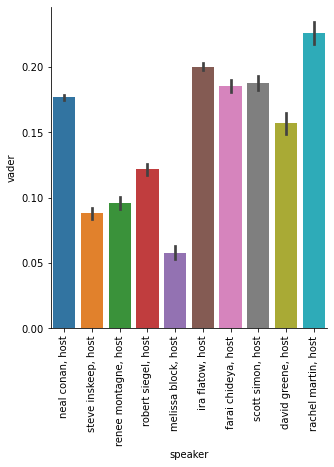

In [38]:
sns.catplot(x="speaker", y="vader", kind="bar", data=top_hosts_df)
plt.xticks(rotation=90);

- Another view of the same...it looks more clear here that there is a difference, however note the small scale on the y axis

In [39]:
top_hosts_df.head(1)

,index,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,month,year
date,,,,,,,,,,,,,
2005-01-11,1793827,84432,85,"neal conan, host",OK.,talk of the nation,difference between a think and a 'blink',True,ok .,ok .,0.296,Jan,2005


### The conclusion to the above is that there is a statistically significant difference in sentiment in the top hosts group, even if it is small.

### Josh's code for the hosts' words

In [40]:
# host_words = train[train.speaker.isin(hosts_with_the_most)].groupby('speaker')['lemmatized'].agg(lambda col: ' '.join(col))

## What's the difference in sentiment score between hosts and non-hosts?

In [41]:
non_host_df = train[train.is_host==False]

Text(0, 0.5, 'Mean Sentiment Score')

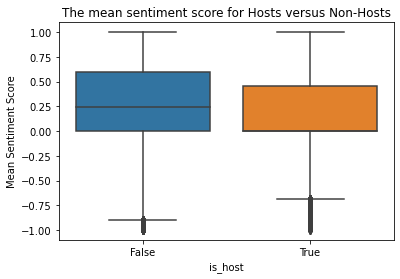

In [42]:
plt.figure
sns.boxplot(data=train, x='is_host',y='vader')
plt.title("The mean sentiment score for Hosts versus Non-Hosts")
plt.ylabel("Mean Sentiment Score")


In [43]:
train[train.is_host==False].vader.mean(), train[train.is_host==True].vader.mean()

(0.18943792704242723, 0.15588023021994188)

In [44]:
null_hypothesis = "Hosts and Non-hosts have the same sentiment score"
alternative_hypothesis = "Hosts and Non-hosts have different sentiment scores"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [45]:
#stats testing on the same
# anova is the wrong test!
from scipy import stats

t, p = stats.ttest_ind(host_df.vader,non_host_df.vader)
t, p

(-43.805557488726414, 0.0)

In [46]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print(f"Evidence does not support the claim that", alternate_hypothesis)

We reject the null hypothesis that Hosts and Non-hosts have the same sentiment score
We move forward with the hypothesis that Hosts and Non-hosts have different sentiment scores


### The average sentiment score for non-hosts is somewhat higher than for the hosts.  To be expected for a relatively neutral news outlet?

## How about sentiment score by year?

In [47]:
train.resample('Y').vader.mean()

date
2005-12-31    0.169318
2006-12-31    0.161386
2007-12-31    0.180956
2008-12-31    0.209603
2009-12-31    0.193803
2010-12-31    0.184554
2011-12-31    0.172069
2012-12-31    0.188927
2013-12-31    0.157618
2014-12-31    0.131946
2015-12-31    0.139144
Freq: A-DEC, Name: vader, dtype: float64

- why don't we have vader scores in 2000-2003 on yearly resampling?

In [48]:
vader_yearly = pd.DataFrame(train.resample('Y').vader.mean())

<AxesSubplot:xlabel='date'>

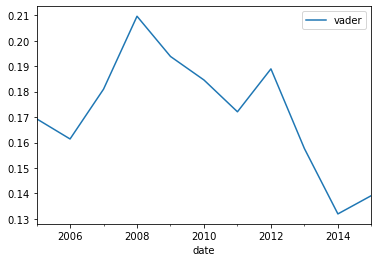

In [49]:
vader_yearly.plot()

In [50]:
vader_monthly = pd.DataFrame(train.resample('M').vader.mean())

In [51]:
vader_monthly.head()

,vader
date,
2005-01-31,0.272687
2005-02-28,NaN
2005-03-31,NaN
2005-04-30,NaN
2005-05-31,0.176331


<AxesSubplot:xlabel='date'>

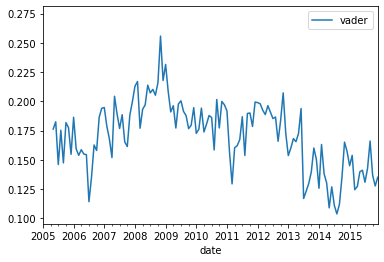

In [52]:
vader_monthly.plot()

- What's with all those missing sentiment scores in the early aughts?
- We eliminated observations pre-2005, they were missing data

In [53]:
# pd.DataFrame(df.resample("d").vader_stopped.mean()).plot()

## By day of week?

In [54]:
train.groupby(train.index.weekday).vader.mean()
# sentiment by day, 0 is monday, 6 is sunday

date
0    0.167613
1    0.166035
2    0.176345
3    0.173886
4    0.197642
5    0.182299
6    0.200146
Name: vader, dtype: float64

<AxesSubplot:xlabel='date', ylabel='vader'>

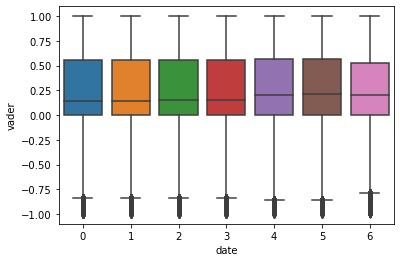

In [55]:
sns.boxplot(data=train, x=train.index.weekday,y='vader')

In [56]:
Monday_df = train[train.index.weekday == 0]
Tuesday_df = train[train.index.weekday == 1]
Wednesday_df = train[train.index.weekday == 2]
Thursday_df = train[train.index.weekday == 3]
Friday_df = train[train.index.weekday == 4]
Saturday_df = train[train.index.weekday == 5]
Sunday_df = train[train.index.weekday == 6]

In [57]:
null_hypothesis = "Different days of the week have the same sentiment score"
alternative_hypothesis = "At least one day of the week has a different sentiment score from the rest"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [58]:
from scipy.stats import f_oneway

f, p = f_oneway(Monday_df.vader,\
Tuesday_df.vader,\
Wednesday_df.vader,\
Thursday_df.vader,\
Friday_df.vader,\
Saturday_df.vader,\
Sunday_df.vader)

f, p

(167.5049242570386, 8.490168446994854e-214)

In [59]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from one weekday to the next")

We reject the null hypothesis that Different days of the week have the same sentiment score
We move forward with the alternative hypothesis that At least one day of the week has a different sentiment score from the rest


## And by program?

In [60]:
train.program.value_counts().index.to_list()

['talk of the nation',
 'morning edition',
 'all things considered',
 'news & notes',
 'weekend edition saturday',
 'weekend edition sunday',
 'day to day']

In [61]:
Talk_of_the_Nation_df = train[train.program == 'talk of the nation']
Morning_Edition_df = train[train.program == 'morning edition']
All_Things_Considered_df = train[train.program == 'all things considered']
News_and_Notes_df = train[train.program == 'news & notes']
Weekend_Edition_Saturday_df = train[train.program == 'weekend edition saturday']
Weekend_Edition_Sunday_df = train[train.program == 'weekend edition sunday']
Day_to_Day_df = train[train.program == 'day to day']


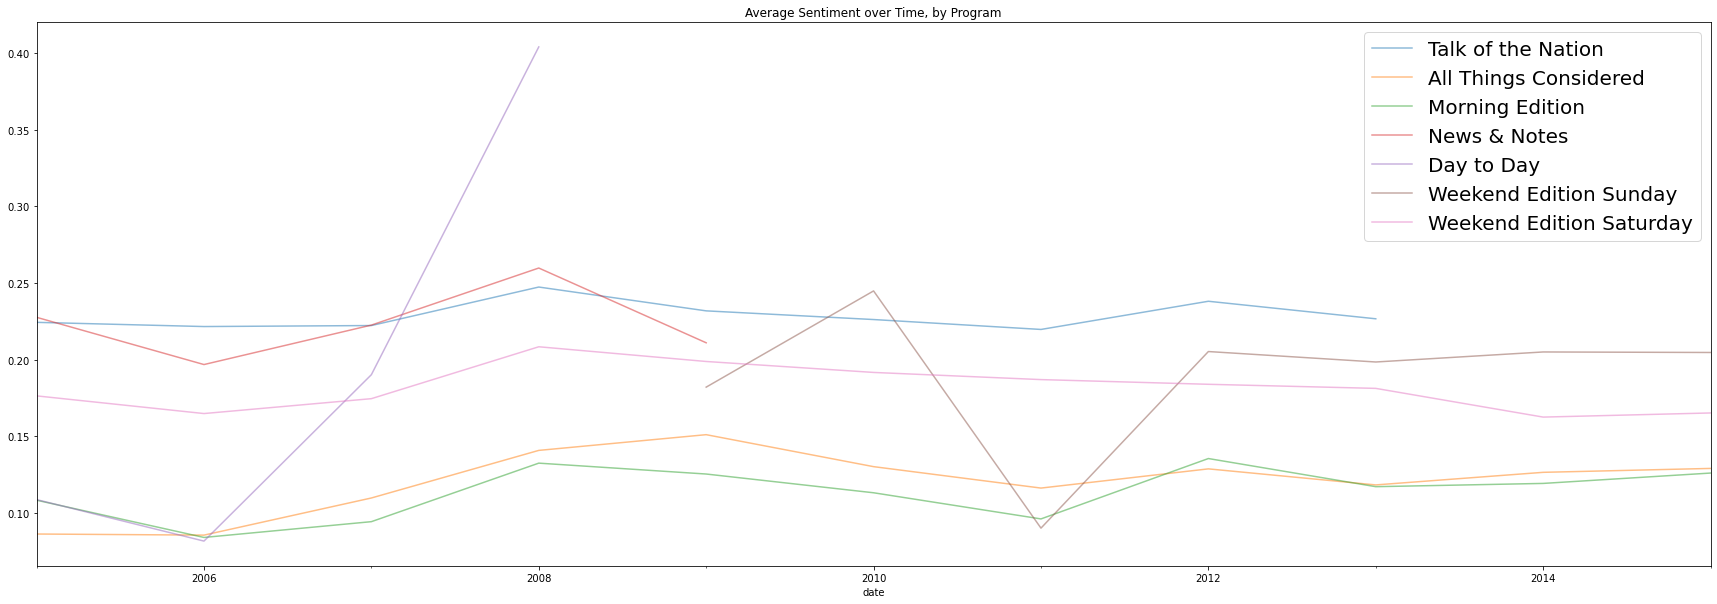

In [62]:
plt.figure(figsize=(30,10))
Talk_of_the_Nation_df.resample("y").vader.mean().plot(alpha=.5)
All_Things_Considered_df.resample("y").vader.mean().plot(alpha=.5)
Morning_Edition_df.resample("y").vader.mean().plot(alpha=.5)
News_and_Notes_df.resample("y").vader.mean().plot(alpha=.5)
Day_to_Day_df.resample("y").vader.mean().plot(alpha=.5)
Weekend_Edition_Sunday_df.resample("y").vader.mean().plot(alpha=.5)
Weekend_Edition_Saturday_df.resample("y").vader.mean().plot(alpha=.5)
plt.title("Average Sentiment over Time, by Program")
plt.legend(['Talk of the Nation',
 'All Things Considered',
 'Morning Edition',
 'News & Notes',
 'Day to Day',
 'Weekend Edition Sunday',
 'Weekend Edition Saturday'], prop={'size': 20})

- Note the programs that have gone off air
- Also, there is some difference in sentiment from program to program
- Weekend Edition (Sat and Sun) have higher sentiment scores--these programs try to be a little on the lighter side for the weekend
- We're definitely starting off the day on the most pessimistic note

In [63]:
null_hypothesis = "The different programs have the same sentiment score"
alternative_hypothesis = "At least one program has a different sentiment score"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [64]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(Talk_of_the_Nation_df.vader,
All_Things_Considered_df.vader,
Morning_Edition_df.vader,
News_and_Notes_df.vader,
Day_to_Day_df.vader,
Weekend_Edition_Sunday_df.vader,
Weekend_Edition_Saturday_df.vader,)
f, p

(3653.823957909019, 0.0)

In [65]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that The different programs have the same sentiment score
We move forward with the alternative hypothesis that At least one program has a different sentiment score


## what about clustering?
- There is very little continuous data here, clusering might not be possible.
- datetime...but how usefull can that be? 
- utterance order? is that available?

In [66]:
train.sort_values(by=['episode_id','episode_order'])[0:50]

,index,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,month,year
date,,,,,,,,,,,,,
2013-06-27,1301002,619,1,"neal conan, host","This is TALK OF THE NATION. I'm Neal Conan, in...",talk of the nation,what's the talk of your nation?,True,"this is talk of the nation. i m neal conan , i...","this is talk of the nation. i m neal conan , i...",0.6757,Jun,2013
2013-06-27,1301003,619,2,"neal conan, host","On our last day, we think it's appropriate for...",talk of the nation,what's the talk of your nation?,True,"on our last day , we think it s appropriate fo...","on our last day , we think it s appropriate fo...",0.9034,Jun,2013
2013-06-27,1301004,619,3,"neal conan, host",And if you want to tell us what's the talk of ...,talk of the nation,what's the talk of your nation?,True,and if you want to tell us what s the talk of ...,and if you want to tell u what s the talk of t...,0.4215,Jun,2013
2013-06-27,1301005,619,4,"neal conan, host",And let's see if we can get Heather on the lin...,talk of the nation,what's the talk of your nation?,True,and let s see if we can get heather on the lin...,and let s see if we can get heather on the lin...,0.0000,Jun,2013
2013-06-27,1301006,619,5,heather,"Hi, yes. I think one of the most important thi...",talk of the nation,what's the talk of your nation?,False,"hi , yes. i think one of the most important th...","hi , yes. i think one of the most important th...",0.6590,Jun,2013
2013-06-27,1301007,619,6,"neal conan, host",And the filibuster the other day by State Sena...,talk of the nation,what's the talk of your nation?,True,and the filibuster the other day by state sena...,and the filibuster the other day by state sena...,0.0000,Jun,2013
2013-06-27,1301008,619,7,heather,"Right, which is absolutely incredible. She des...",talk of the nation,what's the talk of your nation?,False,"right , which is absolutely incredible. she de...","right , which is absolutely incredible. she de...",0.7713,Jun,2013
2013-06-27,1301009,619,8,"neal conan, host",And you know that the governor plans to call a...,talk of the nation,what's the talk of your nation?,True,and you know that the governor plans to call a...,and you know that the governor plan to call an...,0.7778,Jun,2013
2013-06-27,1301010,619,9,heather,"I do know that, and I'm incredibly disappointe...",talk of the nation,what's the talk of your nation?,False,"i do know that , and i m incredibly disappoint...","i do know that , and i m incredibly disappoint...",-0.5256,Jun,2013


### Ok, for the first time I'm seeing clearly how the episodes are in fact ordered by 'story' (episode_id) and then ordered by utterance within the story

### This is great, bc it's what is going to make topic modeling possible down the line

# First...
- Let's do a tsa model of sentiment using Prophet : )

In [67]:
train.columns

Index(['index', 'episode_id', 'episode_order', 'speaker', 'utterance',
       'program', 'title', 'is_host', 'clean', 'lemmatized', 'vader', 'month',
       'year'],
      dtype='object')

In [68]:
for_tsa_modeling_df = pd.DataFrame(df['vader'])

In [69]:
for_tsa_modeling_df.head()

,vader
date,
2005-01-11,0.2960
2005-01-11,0.4019
2005-01-11,0.0000
2005-01-11,0.7906
2005-01-11,-0.8548


In [70]:
# for_prophet_df.resample('Y').mean()
for_tsa_modeling_df.index.year.value_counts()

2007    213708
2008    190844
2009    180095
2010    179388
2012    176305
2006    173052
2011    172823
2013    130009
2005    102972
2014     77886
2015     68049
2016     65271
2017     64242
2018     53154
2019     42059
Name: date, dtype: int64

- there is NOTHING in there fro 2000 to 2003
- 2004 barely a thing

In [71]:

tsa_train = for_tsa_modeling_df['2005':'2015']
tsa_validate = for_tsa_modeling_df['2016':'2017']
tsa_test = for_tsa_modeling_df['2018':]
tsa_train.shape, tsa_validate.shape, tsa_test.shape

((1665131, 1), (129513, 1), (95213, 1))

- I've dropped all observations prior to 2005 in this split due to the problem with the data

In [72]:
tsa_train[-1:], tsa_validate[:1], tsa_validate[-1:], tsa_test[:1]

(             vader
 date              
 2015-12-31  0.0129,
              vader
 date              
 2016-01-01  0.3818,
              vader
 date              
 2017-12-29  0.4019,
              vader
 date              
 2018-01-01  0.6597)

- the splits look good

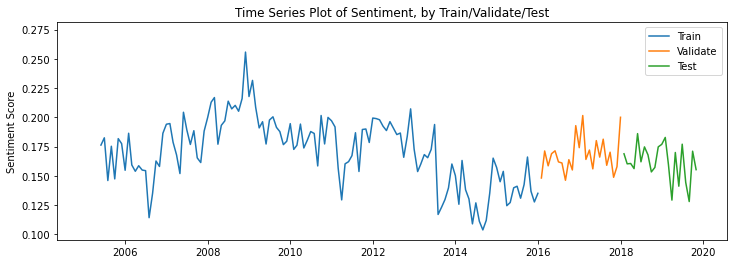

In [73]:
# for col in prophet_train.columns:
plt.figure(figsize=(12,4))
plt.plot(tsa_train.resample('M').vader.mean())
plt.plot(tsa_validate.resample('M').vader.mean())
plt.plot(tsa_test.resample('M').vader.mean())
plt.ylabel('Sentiment Score')
plt.title('Time Series Plot of Sentiment, by Train/Validate/Test')
plt.legend(labels = ["Train","Validate","Test"])
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

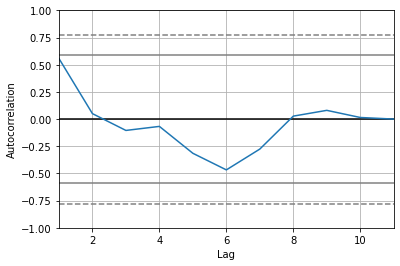

In [74]:
pd.plotting.autocorrelation_plot(tsa_train.resample('y').mean())

- There doesn't look to be any seasonality to speak of--try running the autocorrelation_plot with different resmample lengths
- from the curriculum:
    - "The dashed lines are a way measure whether the observed autocorrelation is a meaningful signal or just white noise. If the majority of the peaks and valleys fall within the dashed lines, the time series is probably white noise."

In [75]:
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

<AxesSubplot:xlabel='date'>

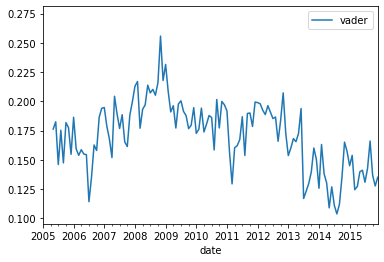

In [76]:
# prophet_train.dropna(axis=0, how='any')
tsa_train.dropna(axis=0, how='any').resample('M').mean().plot()

In [77]:
tsa_train[tsa_train.vader.isnull() == True]

,vader
date,


In [78]:
# tsa_train['vader_stopped'] = tsa_train['vader_stopped'].fillna(0)

In [79]:
# sm.tsa.seasonal_decompose(tsa_train.resample('M').mean()).plot()


# _ = sm.tsa.seasonal_decompose(tsa_train['vader_stopped'].resample('W').mean()).plot()


# ValueError: This function does not handle missing values


### Simple Average Model

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [81]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [82]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [83]:
score = round(tsa_train['vader'].mean(), 4)

def make_predictions():
    yhat_df = pd.DataFrame({'vader': score}, index = validate.index)

    return yhat_df

yhat_df = make_predictions()

In [84]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(tsa_train[target_var].resample('M').mean(), label = 'Train', linewidth = 1)
    plt.plot(tsa_validate[target_var].resample('M').mean(), label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [85]:
# plot and evaluate 
def plot_and_eval_2(target_var,model_type):
    plt.figure(figsize = (12,4))
    plt.plot(tsa_train[target_var].resample('M').mean(), label = 'Train', linewidth = 1)
    plt.plot(tsa_validate[target_var].resample('M').mean(), label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(f"{target_var}, {model_type}")
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [86]:
yhat_df.head()

,vader
date,
2016-01-01,0.1774
2016-01-01,0.1774
2016-01-01,0.1774
2016-01-01,0.1774
2016-01-01,0.1774


vader -- RMSE: 0.4786


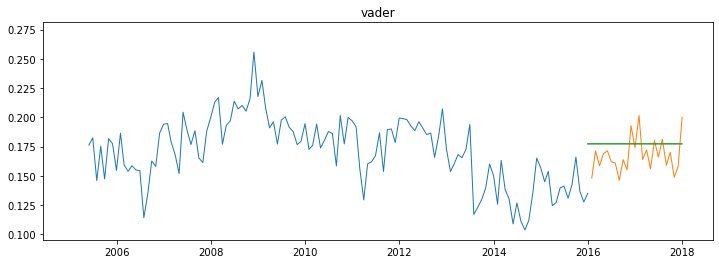

In [87]:
plot_and_eval('vader')

In [88]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = 'vader')

In [89]:
eval_df

,model_type,target_var,rmse
0,simple_average,vader,0.4786


### Moving Average

In [90]:
train['vader'].rolling(3).mean()

date
2005-01-11         NaN
2005-01-11         NaN
2005-01-11    0.232633
2005-01-11    0.397500
2005-01-11   -0.021400
                ...   
2015-12-31   -0.045567
2015-12-31   -0.261767
2015-12-31   -0.179800
2015-12-31    0.099500
2015-12-31    0.320000
Name: vader, Length: 1665131, dtype: float64

vader -- RMSE: 0.4792


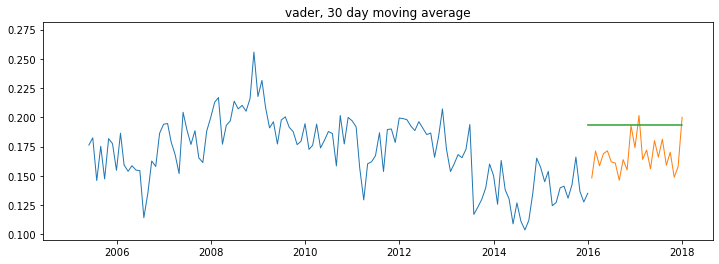

vader -- RMSE: 0.4865


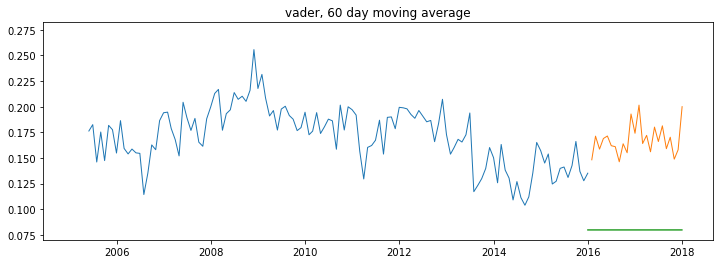

vader -- RMSE: 0.4838


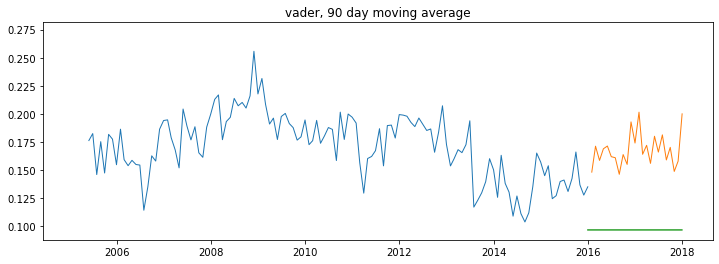

vader -- RMSE: 0.4786


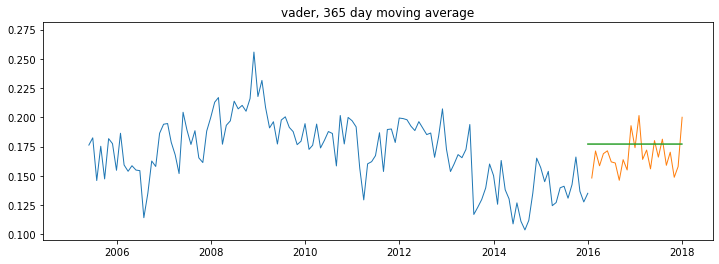

,model_type,target_var,rmse
0,simple_average,vader,0.4786
1,30 day moving average,vader,0.4792
2,60 day moving average,vader,0.4865
3,90 day moving average,vader,0.4838
4,365 day moving average,vader,0.4786


In [91]:
# Trying with different periods

periods = [30, 60, 90, 365]

for p in periods:
    score = round(tsa_train['vader'].rolling(p).mean().iloc[-1], 4)
    yhat_df = make_predictions()
    model_type = str(p) + ' day moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'vader'
                            )
    plot_and_eval_2('vader', model_type)
eval_df

In [92]:
yhat_df

,vader
date,
2016-01-01,0.1772
2016-01-01,0.1772
2016-01-01,0.1772
2016-01-01,0.1772
2016-01-01,0.1772
...,...
2017-12-29,0.1772
2017-12-29,0.1772
2017-12-29,0.1772


# In case you missed it: there's something wrong with the moving average models.  Or am I wrong?


In [93]:
# _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
# plt.show()

# Still having problems loooking at seasonl decomposition due to missing valuese

In [94]:
tsa_validate.index[-1]

Timestamp('2017-12-29 00:00:00')

In [95]:
tsa_train['vader'].resample('M').mean()

date
2005-01-31    0.272687
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
2005-05-31    0.176331
                ...   
2015-08-31    0.142616
2015-09-30    0.166131
2015-10-31    0.136887
2015-11-30    0.127784
2015-12-31    0.135150
Freq: M, Name: vader, Length: 132, dtype: float64

In [96]:
# model = Holt(tsa_train['vader'], exponential = False)
# model = model.fit(smoothing_level = .1, 
#                   smoothing_slope = .1, 
#                   optimized = False)
# yhat_items = model.predict(start = tsa_validate.index[0], 
#                            end = tsa_validate.index[-1])
# yhat_df['vader'] = round(yhat_items, 4)

# #HOLTS IS BROKEN : (

# # KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'


In [97]:
# yhat_df.head()
# the above is returning NaNs only

In [98]:
# plot_and_eval('vader')

### Moving prophet model to its own notebook bc of the size of it (not pushing to github)

## The confidence intervals on the Prophet model were massive.  The sentiment observations in this data are very close together and yield rather little predictive power

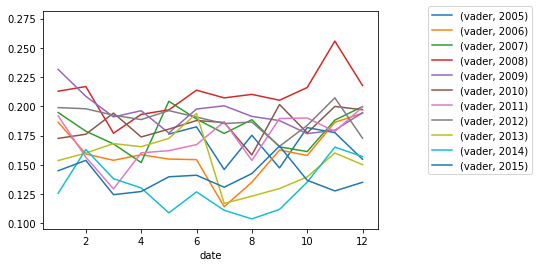

In [99]:
tsa_train.groupby([tsa_train.index.year, tsa_train.index.month]).mean().unstack(0).plot()
plt.legend(loc=(1.3,.5), bbox_to_anchor=(0.5, 0., 0.5, 0.5))

- Is there a trend of dipping sentiment in the summer?
- Also, it seems like the vader scores are lower in the later years

In [100]:
train.head()

,index,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,month,year
date,,,,,,,,,,,,,
2005-01-11,1793827,84432,85,"neal conan, host",OK.,talk of the nation,difference between a think and a 'blink',True,ok .,ok .,0.2960,Jan,2005
2005-01-11,1793772,84432,29,"mr. malcolm gladwell (author, ""blink"")",Yes.,talk of the nation,difference between a think and a 'blink',False,yes .,yes .,0.4019,Jan,2005
2005-01-11,1793773,84432,30,gabriel (caller),...the differences were taken for essence. I'...,talk of the nation,difference between a think and a 'blink',False,... the differences were taken for essence. i ...,... the difference were taken for essence. i l...,0.0000,Jan,2005
2005-01-11,1793774,84432,31,"neal conan, host","OK, thanks for the call, Gabriel. Thanks.",talk of the nation,difference between a think and a 'blink',True,"ok , thanks for the call , gabriel. thanks .","ok , thanks for the call , gabriel. thanks .",0.7906,Jan,2005
2005-01-11,1793775,84432,32,"mr. malcolm gladwell (author, ""blink"")",I think that's a really interesting and import...,talk of the nation,difference between a think and a 'blink',False,i think that s a really interesting and import...,i think that s a really interesting and import...,-0.8548,Jan,2005


In [101]:
train.dtypes

index              int64
episode_id         int64
episode_order      int64
speaker           object
utterance         object
program           object
title             object
is_host             bool
clean             object
lemmatized        object
vader            float64
month             object
year               int64
dtype: object

## HOLD ON: create new splits to be used for the bag_of_words modeling

In [102]:
# df = wrangle.get_npr_data()


# df.date = pd.to_datetime(df.date)


# df['month']=df['date'].dt.strftime('%b')
# df['year']=pd.DatetimeIndex(df['date']).year
# df=df.reset_index()



# df=df.set_index('date').sort_index()


# df = df[df.index.year >= 2005]

In [103]:
df.head()

,index,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,month,year
date,,,,,,,,,,,,,
2005-01-11,1793827,84432,85,"neal conan, host",OK.,talk of the nation,difference between a think and a 'blink',True,ok .,ok .,0.2960,Jan,2005
2005-01-11,1793772,84432,29,"mr. malcolm gladwell (author, ""blink"")",Yes.,talk of the nation,difference between a think and a 'blink',False,yes .,yes .,0.4019,Jan,2005
2005-01-11,1793773,84432,30,gabriel (caller),...the differences were taken for essence. I'...,talk of the nation,difference between a think and a 'blink',False,... the differences were taken for essence. i ...,... the difference were taken for essence. i l...,0.0000,Jan,2005
2005-01-11,1793774,84432,31,"neal conan, host","OK, thanks for the call, Gabriel. Thanks.",talk of the nation,difference between a think and a 'blink',True,"ok , thanks for the call , gabriel. thanks .","ok , thanks for the call , gabriel. thanks .",0.7906,Jan,2005
2005-01-11,1793775,84432,32,"mr. malcolm gladwell (author, ""blink"")",I think that's a really interesting and import...,talk of the nation,difference between a think and a 'blink',False,i think that s a really interesting and import...,i think that s a really interesting and import...,-0.8548,Jan,2005


In [111]:
df = df.dropna()

In [112]:
df.dtypes

index              int64
episode_id         int64
episode_order      int64
speaker           object
utterance         object
program           object
title             object
is_host             bool
clean             object
lemmatized        object
vader            float64
month             object
year               int64
dtype: object

In [122]:
df.speaker = df.speaker.astype('str')

In [146]:
df.groupby('speaker').filter(lambda x : len(x)==1)

,index,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,month,year
date,,,,,,,,,,,,,
2005-01-11,1793846,84432,104,and an e-mail getting to that point you were t...,'How can you learn to trust your intuitio...,talk of the nation,difference between a think and a 'blink',False,how can you learn to trust your intuition and ...,how can you learn to trust your intuition and ...,0.3527,Jan,2005
2005-01-11,2637827,84433,9,"mr. michael chertoff (nominee, secretary of ho...","Mr. President, I think you for your leade...",talk of the nation,bush picks judge to head homeland security,False,"mr. president , i think you for your leadershi...","mr. president , i think you for your leadershi...",0.9638,Jan,2005
2005-05-02,469794,133182,18,professor howard eglit (chicago kent college o...,The money they are generating by way of b...,morning edition,legal firm faces age-bias lawsuit,False,the money they are generating by way of billin...,the money they are generating by way of billin...,0.4767,May,2005
2005-05-02,927963,133179,23,mr. william faulkner,Leaving no room in his workshop for anything b...,morning edition,literary pilgrims flock to faulkner's home,False,leaving no room in his workshop for anything b...,leaving no room in his workshop for anything b...,0.9670,May,2005
2005-05-02,927954,133179,14,ms. hendricks,"If you can't find him here, I don't know where...",morning edition,literary pilgrims flock to faulkner's home,False,"if you can t find him here , i don t know wher...","if you can t find him here , i don t know wher...",0.0000,May,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-12,630466,720,16,joshua hostetter,"I'm going to miss it - it's - to be honest, be...",weekend edition saturday,renaming the dixie classic fair\n ...,True,"i m going to miss it it s to be honest , becau...","i m going to miss it it s to be honest , becau...",-0.1901,Oct,2019
2019-10-12,195209,714,7,jafar said,A disaster is going on in Rojava. And main cau...,weekend edition saturday,civilians flee turkish incursion,False,a disaster is going on in rojava. and main cau...,a disaster is going on in rojava. and main cau...,-0.6249,Oct,2019
2019-10-12,195216,714,14,steve gumaer,"They're distributing blankets, mats and food f...",weekend edition saturday,civilians flee turkish incursion,False,"they re distributing blankets , mats and food ...","they re distributing blanket , mat and food fo...",0.4939,Oct,2019


In [114]:
from sklearn.model_selection import train_test_split



cv_train, cv_test = train_test_split(df, test_size = .2, random_state=123, stratify= df.speaker)
cv_train, cv_validate = train_test_split(cv_train, test_size=.3, random_state=123, stratify= train.speaker)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
X_train = train.drop(columns=['tax_value'])
y_train = pd.DataFrame(train.tax_value, columns=['tax_value'])

X_validate = validate.drop(columns=['tax_value'])
y_validate = pd.DataFrame(validate.tax_value, columns=['tax_value'])

X_test = test.drop(columns=['tax_value'])
y_test = pd.DataFrame(test.tax_value, columns=['tax_value'])

In [107]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X_bag_of_words= cv.fit_transform(X_train)


In [108]:
X_validate = 

SyntaxError: invalid syntax (<ipython-input-108-9060fefc7345>, line 1)

In [ ]:
len(cv.vocabulary_)

### The below cells are for TF-IDF modeling, which crashed the old macbookpro last night.  If attempting to run again, let's do so on a smaller sample of the data.
- I was able to tfidf vectorize, just running the lm model was an issue

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer()
# X_train = tfidf.fit_transform(train.lemmatized_stopped)
# y_train = train.speaker


In [ ]:
# X_validate = tfidf.transform(validate.lemmatized_stopped)
# y_validate = validate.speaker

# X_test = tfidf.transform(test.lemmatized_stopped)
# y_test = test.speaker

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# lm = LogisticRegression().fit(X_train, y_train)

# train = pd.DataFrame(dict(actual=y_train))
# test = pd.DataFrame(dict(actual=y_test))

# train['predicted'] = lm.predict(X_train)
# validate['predicted'] = lm.predict(X_validate)


In [ ]:
# print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
# print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
# print(classification_report(train.actual, train.predicted))